In [34]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.layers import CuDNNLSTM

In [35]:
train_df = pd.read_csv("../project/input/train.csv")

print("Train shape : ",train_df.shape)


Train shape :  (1306122, 3)


In [36]:
## Config values 
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=2019)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=2020)
print("Validation shape : ",val_df.shape)
print("Test shape : ",test_df.shape)
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 50 # max number of words in a question to use

## fill up the missing values
train_X = train_df["question_text"].fillna("_na_").values
val_X = val_df["question_text"].fillna("_na_").values
test_X = test_df["question_text"].fillna("_na_").values

## Tokenize the sentences
oov_tok = "OOV_TOK"
tokenizer = Tokenizer(num_words=max_features) # lower = False, oov_token=oov_tok)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen, truncating='post')
val_X = pad_sequences(val_X, maxlen=maxlen, truncating='post')
test_X = pad_sequences(test_X, maxlen=maxlen, truncating='post')

## Get the target values
train_y = train_df['target'].values
val_y = val_df['target'].values
test_y = test_df['target'].values

Validation shape :  (130612, 3)
Test shape :  (130613, 3)


In [37]:
EMBEDDING_FILE = '../project/input/embeddings/glove.840B.300d/glove.840B.300d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        

/home/user1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """


In [40]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 50, 300)           15000000  
_________________________________________________________________
bidirectional_7 (Bidirection (None, 50, 128)           187392    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total para

In [41]:
model.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y))

Train on 1044897 samples, validate on 130612 samples
Epoch 1/2
1044897/1044897 [==============================] - 47s 45us/sample - loss: 0.1199 - acc: 0.9523 - val_loss: 0.1084 - val_acc: 0.9581
Epoch 2/2
1044897/1044897 [==============================] - 48s 46us/sample - loss: 0.0966 - acc: 0.9616 - val_loss: 0.1034 - val_acc: 0.9588


In [45]:
pred_glove_val_y = model.predict([val_X], batch_size=1024, verbose=1)
threshold = []
f1_array = []
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    threshold.append(thresh)
    f1_score = metrics.f1_score(val_y, (pred_glove_val_y>thresh).astype(int))
    f1_array.append(f1_score)
    print("F1 score at threshold {0} is {1}".format(thresh, f1_score))

130612/130612 [==============================] - 1s 10us/sample
F1 score at threshold 0.1 is 0.6004176077044361
F1 score at threshold 0.11 is 0.609571129707113
F1 score at threshold 0.12 is 0.617449066024698
F1 score at threshold 0.13 is 0.6230461650308978
F1 score at threshold 0.14 is 0.6286718786140538
F1 score at threshold 0.15 is 0.6324054918186948
F1 score at threshold 0.16 is 0.6365893249307744
F1 score at threshold 0.17 is 0.641110248447205
F1 score at threshold 0.18 is 0.6443481685703032
F1 score at threshold 0.19 is 0.6470118726928066
F1 score at threshold 0.2 is 0.6497446528796076
F1 score at threshold 0.21 is 0.6517026280805809
F1 score at threshold 0.22 is 0.6539455993380908
F1 score at threshold 0.23 is 0.6562826677817271
F1 score at threshold 0.24 is 0.6589491489586637
F1 score at threshold 0.25 is 0.6604328079080951
F1 score at threshold 0.26 is 0.6612293399589501
F1 score at threshold 0.27 is 0.6619764397905759
F1 score at threshold 0.28 is 0.6611141753998897
F1 score a

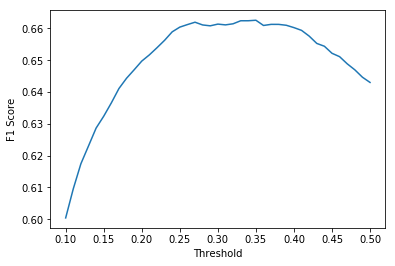

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.plot(threshold, f1_array)
plt.show()
fig.savefig('F1_score')

In [43]:
pred_glove_test_y = model.predict([test_X], batch_size=1024, verbose=1)
test_y = test_df['target'].values
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    f1_score = metrics.f1_score(test_y, (pred_glove_test_y>thresh).astype(int))
    print("F1 score at threshold {0} is {1}".format(thresh, f1_score))


130613/130613 [==============================] - 1s 10us/sample
F1 score at threshold 0.1 is 0.6080937619431822
F1 score at threshold 0.11 is 0.6150177750802046
F1 score at threshold 0.12 is 0.6225071854963519
F1 score at threshold 0.13 is 0.6281416088640662
F1 score at threshold 0.14 is 0.6341150016061677
F1 score at threshold 0.15 is 0.640216579536968
F1 score at threshold 0.16 is 0.6445380936597378
F1 score at threshold 0.17 is 0.6490899486145129
F1 score at threshold 0.18 is 0.6526162083231929
F1 score at threshold 0.19 is 0.6556471110672522
F1 score at threshold 0.2 is 0.6588612028419893
F1 score at threshold 0.21 is 0.6621080889429165
F1 score at threshold 0.22 is 0.664923076923077
F1 score at threshold 0.23 is 0.6676335008028177
F1 score at threshold 0.24 is 0.669495965629257
F1 score at threshold 0.25 is 0.6715351643117956
F1 score at threshold 0.26 is 0.6730501765272281
F1 score at threshold 0.27 is 0.6744449846054124
F1 score at threshold 0.28 is 0.6759794827021718
F1 score a